In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_pipeline = Pipeline([('MinMaxScaler',MinMaxScaler(feature_range=(-1,1))) ])
label_pipeline = Pipeline([('MinMaxScaler',MinMaxScaler(feature_range=(-1,1))) ])
enc = OneHotEncoder()

#enc = LabelBinarizer()

In [ ]:
def generate_real_sample(tau_p4):
  n   = tau_p4.shape[0]
  _px = tau_p4['gentau_vis_px'].to_numpy(dtype='float32').reshape(n,1)
  _py = tau_p4['gentau_vis_py'].to_numpy(dtype='float32').reshape(n,1)
  _pz = tau_p4['gentau_vis_pz'].to_numpy(dtype='float32').reshape(n,1)
  _e  = tau_p4['gentau_vis_e'].to_numpy(dtype='float32').reshape(n,1)
  _pt  = tau_p4['gentau_vis_pt'].to_numpy(dtype='float32').reshape(n,1)
  _eta = tau_p4['gentau_vis_eta'].to_numpy(dtype='float32').reshape(n,1)
  _phi = tau_p4['gentau_vis_phi'].to_numpy(dtype='float32').reshape(n,1)
  _met_px = tau_p4['genmet_px'].to_numpy(dtype='float32').reshape(n,1)
  _met_py = tau_p4['genmet_py'].to_numpy(dtype='float32').reshape(n,1)
  _met_phi = tau_p4['genmet_phi'].to_numpy(dtype='float32').reshape(n,1)
  _met = tau_p4['genmet'].to_numpy(dtype='float32').reshape(n,1)
  _mT = tau_p4['gen_mT'].to_numpy(dtype='float32').reshape(n,1)
  _class_id = tau_p4['class_id'].to_numpy(dtype='float32').reshape(n,1)/8000.0
  _label_id = enc.fit_transform(_class_id)
  X = np.hstack((_px,_py,_pz,_e,_met_px,_met_py,_mT))
  M = tau_p4['boson_mass'].to_numpy(dtype='float32').reshape(n,1)
  W = tau_p4['event_weight'].to_numpy(dtype='float32').reshape(n,1)

  #print(_label_id.shape)
  return X,M,_class_id

In [ ]:
InputDataset  = pd.read_csv('/content/drive/MyDrive/GAN_Regression/data_fine/train.csv',index_col=None )
InputDataset .fillna(value=InputDataset .mean(),inplace=True)

TestDataSet_3 = pd.read_csv('/content/drive/MyDrive/GAN_Regression/data_fine/test_back.csv',index_col=False)
TestDataSet_4 = pd.read_csv('/content/drive/MyDrive/GAN_Regression/data_fine/test_3000.csv',index_col=False)
TestDataSet_5 = pd.read_csv('/content/drive/MyDrive/GAN_Regression/data_fine/test_4000.csv',index_col=False)
TestDataSet_6 = pd.read_csv('/content/drive/MyDrive/GAN_Regression/data_fine/test_5000.csv',index_col=False)
TestDataSet_7 = pd.read_csv('/content/drive/MyDrive/GAN_Regression/data_fine/test_6000.csv',index_col=False)


TestDataSet_3.fillna(value=TestDataSet_3.mean(),inplace=True)
TestDataSet_4.fillna(value=TestDataSet_4.mean(),inplace=True)
TestDataSet_5.fillna(value=TestDataSet_5.mean(),inplace=True)
TestDataSet_6.fillna(value=TestDataSet_6.mean(),inplace=True)
TestDataSet_7.fillna(value=TestDataSet_7.mean(),inplace=True)

TestDataSets = [TestDataSet_3,TestDataSet_4,TestDataSet_5,TestDataSet_6,TestDataSet_7]


In [ ]:
train_feature,train_label,train_weight = generate_real_sample(InputDataset)
xstar_param_samples = []
xstar_samples =[]
ystar_samples = []
#idtrain_samples = []
idstar_samples = []
for TestDataSet in TestDataSets:
  test_feature,test_label,test_weight = generate_real_sample(TestDataSet)
  train_test_feature = np.concatenate((train_feature,test_feature),axis=0)
  train_test_labels  = np.concatenate((train_label,test_label),axis=0)

  train_test_dataset = num_pipeline.fit_transform(train_test_feature)

  xtrain = train_test_dataset[:len(train_feature)]
  ytrain = train_test_labels[:len(train_feature)]
  #ytrain = train_test_class[:len(train_feature)]

  ytrain_ = label_pipeline.fit_transform(ytrain)
  #xtrain_param = np.concatenate((xtrain,train_weight),axis=1)

  #xstar_param  = np.concatenate((train_test_dataset[len(train_feature):],test_weight),axis=1)
  xstar = train_test_dataset[len(train_feature):]
  #xstar_param_samples.append(xstar_param)
  xstar_samples.append(xstar)
  #ystar_samples.append(train_test_labels[len(train_feature):])
  ystar_samples.append(train_test_labels[len(train_feature):])

print('Train dataset shape: ',train_test_labels.shape)
#train_weight
print(train_weight[1])

Train dataset shape:  (261001, 1)
[0.46875]


In [ ]:
class mANregression(keras.Model):
    def __init__(self,ninputs):
        super(mANregression,self).__init__()
        self.classifier = self.build_discriminator(ninputs)
        self.regressor     = self.build_generator(ninputs)
        #self.real_id = real_id

    def build_classifier(self,ninput):
        keras.layers.Conv2D(32, (3,3), padding='same', activation='relu',input_shape=(200, 200, 3))

    def build_regressor(self,latent_dim):
        in_label =  keras.layers.Input(shape=(1,))
        n_nodes = 7 * 7
        li = keras.layers.Dense(n_nodes)(in_label)
        li = keras.layers.Reshape((7, 7, 1))(li)
        # image generator input
        in_lat =  keras.layers.Input(shape=(latent_dim,))
        # foundation for 7x7 image
        n_nodes = 128 * 7 * 7
        gen = keras.layers.Dense(n_nodes)(in_lat)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = keras.layers.Reshape((7, 7, 128))(gen)
        # merge image gen and label input
        merge =  keras.layers.Concatenate()([gen, li])
        # upsample to 14x14
        gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
        gen = LeakyReLU(alpha=0.2)(gen)
        # upsample to 28x28
        gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        # output
        out_layer = keras.layers.Conv2D(1, (7,7), padding='same')(gen)
        out_layer = keras.layers.Flatten()(out_layer)
        out_layer = keras.layers.Dense(1, activation='linear')(out_layer)
        # define model
        model =  keras.models.Model([in_lat, in_label], out_layer)
        return model

    def build_discriminator(self,ninput):
        dis_input = layers.Input((ninput,))
        layer = layers.Dense(32,activation ='relu', kernel_initializer='he_uniform')(dis_input)
        #layer = LeakyReLU(alpha=0.1)(layer)
        layer  = keras.layers.BatchNormalization()(layer)
        #layer = layers.Dense(200,activation ='relu', kernel_initializer='he_uniform')(layer)
        #layer = LeakyReLU(alpha=0.1)(layer)
        #layer  = keras.layers.BatchNormalization()(layer)
        layer = layers.Dense(32,activation ='relu', kernel_initializer='he_uniform')(layer)
        #layer = LeakyReLU(alpha=0.1)(layer)
        layer  = keras.layers.BatchNormalization()(layer)
        #layer = layers.Dense(5,activation ='relu', kernel_initializer='he_uniform')(layer)
        out_layer = layers.Dense(1,activation='sigmoid')(layer)
        model = tf.keras.Model(dis_input,out_layer)
        return model

    def build_generator(self,input_dim):
        gen_input = layers.Input((input_dim,))
        dis_ouput = layers.Input((1,))

        merge_input = keras.layers.Concatenate()([gen_input,dis_ouput])
        layer = layers.Dense(100,activation ='relu', kernel_initializer='he_uniform')(merge_input)
        layer = LeakyReLU(alpha=0.1)(layer)
        layer  = keras.layers.BatchNormalization()(layer)
        #layer = layers.Dense(200,activation ='relu', kernel_initializer='he_uniform')(layer)
        #layer = layers.Dense(200,activation ='relu', kernel_initializer='he_uniform')(layer)
        layer = layers.Dense(16,activation ='relu', kernel_initializer='he_uniform')(layer)
        out_layer = layers.Dense(1,activation='linear')(layer)
        model = tf.keras.Model([gen_input,dis_ouput],out_layer)
        return model

    def build_generator_pm(self,input_dim):
        gen_input = layers.Input((input_dim,))
        #dis_ouput = layers.Input((1,))
        #merge_input = keras.layers.Concatenate()([gen_input,dis_ouput])
        layer = layers.Dense(32,activation ='relu', kernel_initializer='he_uniform')(gen_input)
        #layer = layers.Dense(200,activation ='relu', kernel_initializer='he_uniform')(layer)
        #layer = layers.Dense(200,activation ='relu', kernel_initializer='he_uniform')(layer)
        layer = layers.Dense(16,activation ='relu', kernel_initializer='he_uniform')(layer)
        out_layer = layers.Dense(1,activation='linear')(layer)
        model = tf.keras.Model(gen_input,out_layer)
        return model

    def compile(self, d_optimizer, g_optimizer, loss_fn, gen_loss_fn):
        super(mANregression, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.gen_loss_fn = gen_loss_fn

    #def get_sample(x,y)

    def train_step(self,data):
      xtrains, ytrain = data
      xtrain = xtrains[0]
      real_id = xtrains[1]
      batch_size = tf.shape(xtrain)[0]
      #ix = tf.random.randint(0, xtrain.shape[0], batch_size)
      #ix_tf = tf.random.uniform(shape=(batch_size,), minval=0, maxval=260000, dtype=tf.int32)
      #print(xtrain)
      #ix = ix_tf.numpy()
      #print('ok1')
      with tf.GradientTape() as tape:
        cls_predictions = self.classifier(xtrain)
        d_loss = self.loss_fn(real_id, cls_predictions)
      grads = tape.gradient(d_loss, self.classifier.trainable_weights)
      self.d_optimizer.apply_gradients(
            zip(grads, self.classifier.trainable_weights)
        )
      fake_id = self.classifier(xtrain)
      #print('ok2')
      with tf.GradientTape() as tape:
        #xinput = tf.concat([xtrain,fake_id],-1)
        predictions = self.regressor([xtrain,fake_id])
        #predictions = self.regressor(xinput)
        g_loss = self.gen_loss_fn(ytrain, predictions)
      grads = tape.gradient(g_loss,self.regressor.trainable_weights)
      self.g_optimizer.apply_gradients(
          zip(grads,self.regressor.trainable_weights)
      )
      #print('ok3')
      self.d_loss_metric.update_state(d_loss)
      #print('ok4')
      self.g_loss_metric.update_state(g_loss)
      #print('ok5')
      return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),

        }




In [ ]:
class mANMonitor(keras.callbacks.Callback):
    def __init__(self,xtest,ytest,prefix,incriment):
        self.incriment = incriment
        self.prefix = prefix
        self.xtest = xtest
        self.ytest = ytest




    def summarise_performance(self,real_boson_mass,fake_boson_mass):
        fig,ax = plt.subplots()
        (n1, bins1, patches1)=ax.hist(real_boson_mass,20,color='blue',label='real')
        (n2, bins2, patches2)=ax.hist(fake_boson_mass,20,color='red',alpha=0.5,label='fake')
        #ax.scatter(real_tau_p4[:,0],real_tau_p4[:,1],color='blue',label='real')
        #ax.scatter(fake_tau_p4[:,0],fake_tau_p4[:,1],color='red',label='fake')

        ax.legend()


    def SaveModels(self,epoch):
        discriminator = self.model.classifier
        generator = self.model.regressor
        #discriminator.trainable = True
        tf.keras.models.save_model(generator,'/content/drive/MyDrive/GAN_Regression/mAN_generator_'+self.prefix+'_'+str(epoch))
        tf.keras.models.save_model(discriminator,'/content/drive/MyDrive/GAN_Regression/mAN_discriminator_'+self.prefix+'_'+str(epoch))

    def on_epoch_end(self, epoch, logs=None):
        class_id = self.model.classifier(self.xtest)
        xinput = np.concatenate((self.xtest,class_id),axis=1)
        self.gen_mass  = self.model.regressor([self.xtest,class_id])
        #self.gen_mass  = self.model.regressor(xinput)
        if epoch % self.incriment == 0 and epoch != 0:
          self.summarise_performance(self.ytest,self.gen_mass[:,0])
          self.SaveModels(epoch)

In [ ]:

gan = mANregression(ninputs=7)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    gen_loss_fn = keras.losses.MeanSquaredError(),
)

Epoch 1/201


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


508/508 [==============================] - 8s 8ms/step - d_loss: 0.6358 - g_loss: 4194963.0000
Epoch 2/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6337 - g_loss: 1820435.7500
Epoch 3/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6330 - g_loss: 1800792.8750
Epoch 4/201
508/508 [==============================] - 4s 7ms/step - d_loss: 0.6319 - g_loss: 1782485.1250
Epoch 5/201
508/508 [==============================] - 4s 8ms/step - d_loss: 0.6314 - g_loss: 1774775.1250
Epoch 6/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6312 - g_loss: 1771639.2500
Epoch 7/201
508/508 [==============================] - 3s 6ms/step - d_loss: 0.6309 - g_loss: 1767694.3750
Epoch 8/201
508/508 [==============================] - 4s 7ms/step - d_loss: 0.6309 - g_loss: 1765383.0000
Epoch 9/201
508/508 [==============================] - 4s 8ms/step - d_loss: 0.6308 - g_loss: 1764242.6250
Epoch 10/201
508/508 [===========================

508/508 [==============================] - 6s 11ms/step - d_loss: 0.6302 - g_loss: 1753194.0000
Epoch 52/201
508/508 [==============================] - 4s 7ms/step - d_loss: 0.6302 - g_loss: 1753292.5000
Epoch 53/201
508/508 [==============================] - 4s 8ms/step - d_loss: 0.6302 - g_loss: 1752627.0000
Epoch 54/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6302 - g_loss: 1753911.0000
Epoch 55/201
508/508 [==============================] - 3s 6ms/step - d_loss: 0.6302 - g_loss: 1752916.0000
Epoch 56/201
508/508 [==============================] - 4s 7ms/step - d_loss: 0.6301 - g_loss: 1751934.3750
Epoch 57/201
508/508 [==============================] - 4s 8ms/step - d_loss: 0.6300 - g_loss: 1751358.3750
Epoch 58/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6301 - g_loss: 1752738.3750
Epoch 59/201
508/508 [==============================] - 3s 6ms/step - d_loss: 0.6302 - g_loss: 1753477.5000
Epoch 60/201
508/508 [==================

508/508 [==============================] - 7s 13ms/step - d_loss: 0.6299 - g_loss: 1749246.1250
Epoch 102/201
508/508 [==============================] - 4s 7ms/step - d_loss: 0.6300 - g_loss: 1749608.8750
Epoch 103/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6300 - g_loss: 1749569.5000
Epoch 104/201
508/508 [==============================] - 3s 6ms/step - d_loss: 0.6300 - g_loss: 1749201.3750
Epoch 105/201
508/508 [==============================] - 4s 8ms/step - d_loss: 0.6300 - g_loss: 1749208.7500
Epoch 106/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6299 - g_loss: 1748736.8750
Epoch 107/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6300 - g_loss: 1748815.8750
Epoch 108/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6300 - g_loss: 1749296.8750
Epoch 109/201
508/508 [==============================] - 4s 8ms/step - d_loss: 0.6300 - g_loss: 1749274.0000
Epoch 110/201
508/508 [=========

508/508 [==============================] - 6s 12ms/step - d_loss: 0.6299 - g_loss: 1747331.7500
Epoch 152/201
508/508 [==============================] - 3s 6ms/step - d_loss: 0.6299 - g_loss: 1747711.5000
Epoch 153/201
508/508 [==============================] - 4s 7ms/step - d_loss: 0.6299 - g_loss: 1747014.8750
Epoch 154/201
508/508 [==============================] - 4s 8ms/step - d_loss: 0.6299 - g_loss: 1747748.1250
Epoch 155/201
508/508 [==============================] - 3s 6ms/step - d_loss: 0.6299 - g_loss: 1747472.5000
Epoch 156/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6299 - g_loss: 1747151.8750
Epoch 157/201
508/508 [==============================] - 4s 8ms/step - d_loss: 0.6300 - g_loss: 1749070.3750
Epoch 158/201
508/508 [==============================] - 4s 8ms/step - d_loss: 0.6299 - g_loss: 1748230.5000
Epoch 159/201
508/508 [==============================] - 3s 7ms/step - d_loss: 0.6299 - g_loss: 1747810.3750
Epoch 160/201
508/508 [=========

508/508 [==============================] - 6s 11ms/step - d_loss: 0.6299 - g_loss: 1747219.6250


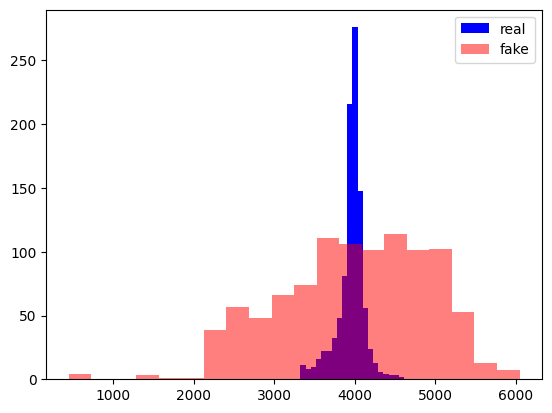

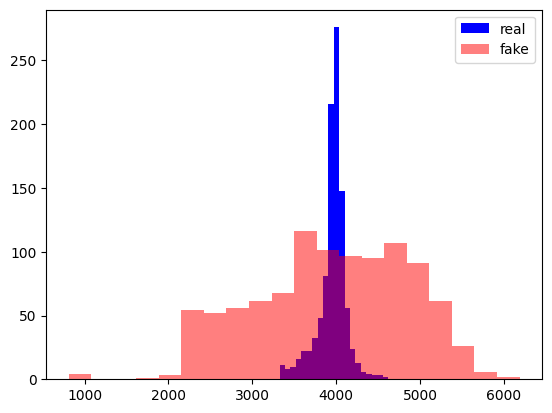

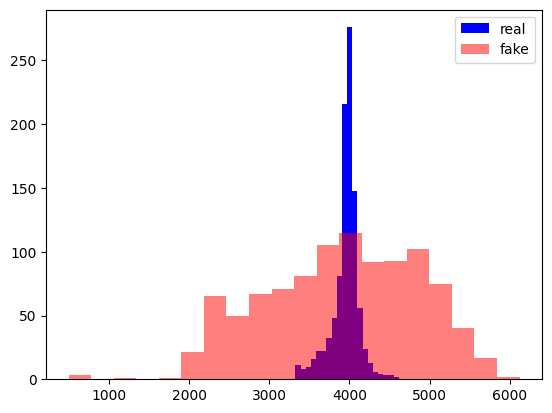

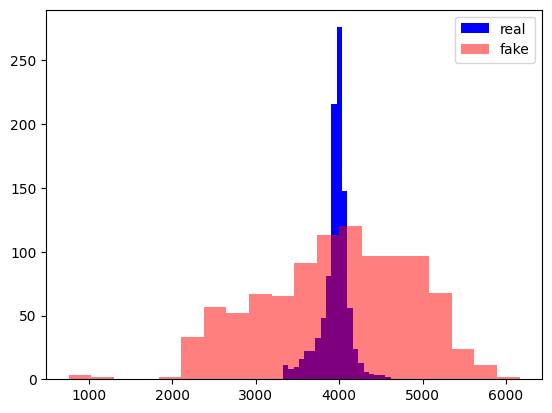

In [ ]:
gan.fit([xtrain,train_weight],ytrain,callbacks=[mANMonitor(xstar_samples[2],ystar_samples[2],'TFdnn_new',50)],epochs=201,batch_size=512,verbose=True)

In [ ]:
load_reg = tf.keras.models.load_model('/content/drive/MyDrive/GAN_Regression/mAN_generator_TFdnn_new_200')
load_cls = tf.keras.models.load_model('/content/drive/MyDrive/GAN_Regression/mAN_discriminator_TFdnn_new_200')
load_dnn = tf.keras.models.load_model('/content/drive/MyDrive/GAN_Regression/h2_al1_lr4_1024_500.h5')

In [ ]:
def load_mAN(reg,cls,xstar):
  id = cls.predict(xstar)

  Y_train, bin_edge = np.histogram(id,bins=20, density=True)
  Y_train = np.insert(Y_train,0,0)

  X_train = np.arange(0,0.8+0.8/20,0.8/20.0)

  kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
  gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
  gaussian_process.fit(X_train.reshape(-1,1),Y_train.reshape(-1,1))

  X = np.linspace(0.1,0.8,100)
  mean_prediction, std_prediction = gaussian_process.predict(X.reshape(-1,1), return_std=True)

  id_max = 0
  for i in range(0,len(X)):
    mean = mean_prediction[i]
    if mean == mean_prediction.max():
      id_max = X[i]
      break

  print(id_max)
  id_hist = np.random.normal(id_max,id.std(),xstar.shape[0])
  #yp = reg.predict([xstar,id])
  yp = reg.predict([xstar,id_hist.reshape(-1,1)])

  return id,yp

32/32 [==============================] - 0s 1ms/step
0.1
32/32 [==============================] - 0s 1ms/step
0.49595959595959593
32/32 [==============================] - 0s 1ms/step
0.602020202020202
32/32 [==============================] - 0s 2ms/step
0.6797979797979798
32/32 [==============================] - 0s 2ms/step


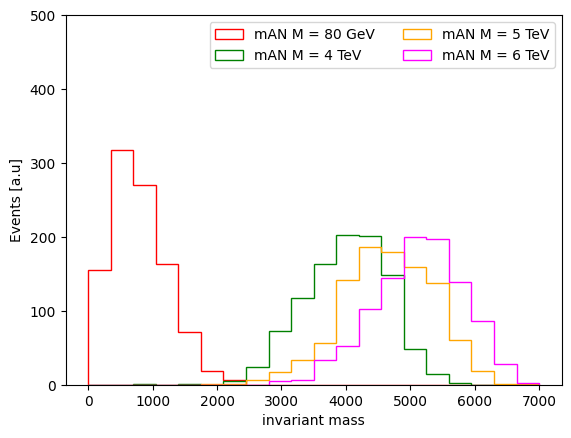

In [ ]:
iter = 0
fig,ax = plt.subplots()
colors = ['red','blue','green','orange','magenta']
mAN_labels = ['mAN M = 80 GeV','mAN M = 3 TeV','mAN M = 4 TeV','mAN M = 5 TeV','mAN M = 6 TeV']
DNN_labels = ['DNN M = 80 GeV','DNN M = 3 TeV','DNN M = 4 TeV','DNN M = 5 TeV','DNN M = 6 TeV']
for xtest in xstar_samples:
  y_true = ystar_samples[iter]
  if iter != 1:
    y_dnn = label_pipeline.inverse_transform(load_dnn.predict(xtest))
    label_id,y_pred = load_mAN(load_reg,load_cls,xtest)
    #print(label_id)
    #ax.hist(label_id,histtype='bar',color=colors[iter],density=True,bins=20,label=mAN_labels[iter],range=(0,0.8))
    ax.hist(y_pred,histtype='step',color=colors[iter],density=False,bins=20,label=mAN_labels[iter],range=(0,7000))
    #ax.hist(y_dnn,histtype='step',color=colors[iter],density=False,bins=20,label=DNN_labels[iter],range=(0,7000),ls='--')
  iter += 1

ax.set_ylim(0,500)
#ax.set_xlim(0,500)
ax.set_xlabel('invariant mass')
ax.set_ylabel('Events [a.u]')
ax.legend(ncol=2)

plt.show()


In [ ]:
ar = np.array([0,1,2,3])

In [ ]:
ar.max()

3

In [ ]:
np.insert(ar,0,-1)

array([-1,  0,  1,  2,  3])

In [ ]:
for i in range(0,10):
  print(i)

0
1
2
3
4
5
6
7
8
9
